In [22]:
#===================================================================
#
#           OBSERVATIONAL FITS FILES REDUCTION
#
# This script is used to overscan, correct, trim, gain correct, 
# substract master bias, master dark, and flat-field the FIT img.
# The script rearanges automatically.
#
# VERSION: 22 Sep 2020
# AUTHOER: QIANG CHEN chen@camk.edu.pl 
#
# PYTHON ENVIRONMENT REQUIREMENT:
# - pip install astropy
# - pip install --no-deps ccdproc
# alternatively can use (CAMK):
#   source /home/chen/python-chen/chen3.6/bin/activate
#
# REFERENCE:
# - (ATUO) Reduction toolbox (astropy) https://ccdproc.readthedocs.io/en/latest/reduction_toolbox.html
# - (RECOMMENDED) REDUCTION EXAMPLE https://nbviewer.jupyter.org/gist/mwcraig/06060d789cc298bbb08e
# - CCD DATA REDUCTION GUIDE https://mwcraig.github.io/ccd-as-book/00-00-Preface.html
# - AVERAGING FITS FILE (astropy) http://learn.astropy.org/FITS-imgs.html
# - SAVE TO FITS FORMAT (astropy) https://docs.lightkurve.org/tutorials/03-making-fits-files.html
# - APERTURE PHOTOMETRY (photutils.aperture) https://photutils.readthedocs.io/en/stable/aperture.html
# - LIGHT CURVES WITH COS (lightcurve) https://justincely.github.io/AAS224/lightcurve_tutorial.html
# - EDIT HEADER http://learn.astropy.org/FITS-header.html
#===================================================================

import glob, os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc
from matplotlib.colors import LogNorm


PATH = '/work/chuck/chen/obs'

folder = '20190822'
data_shape = (2199, 2749)
filters = ['V','B','U','I']


biass = []
darks = []
flats = []
lights = []
excludes = []

In [25]:
imgs = glob.glob(f'{PATH}/{folder}/*.fit')
print('TOTAL IMAGES',len(imgs))

print('Removing strange and re-aranging images')
for img in imgs:
  data,header = fits.getdata(img,header=True)
  #print('  img',img, imgs.index(img),'/',len(imgs))
  if (data.shape != data_shape):
    #print('  Exclude:',img,', data shape',data.shape,', TYP',header['IMAGETYP'],', EXPTIME :', header['EXPTIME'])
    excludes.append(img)
  else:
    if (header['IMAGETYP'] == 'Dark Frame'):
      darks.append(img)
    elif (header['IMAGETYP'] == 'Light Frame'):
      lights.append(img)
      #print('  img',img,', data shape',data.shape,', TYP',header['IMAGETYP'],'filter',header['FILTER'],', EXPTIME :', header['EXPTIME'])
    elif (header['IMAGETYP'] == 'Bias Frame'):
      biass.append(img)
    elif (header['IMAGETYP'] == 'Flat Field'):
      flats.append(img)
      #print('  ',img,data.shape,header['IMAGETYP'],'filter',header['FILTER'],', EXPTIME :', header['EXPTIME'])
    else:
      print('  strange:',img,data.shape,header['IMAGETYP'],', EXPTIME :', header['EXPTIME'])

print('  Excludes',len(excludes))
print('  Total residue',len(imgs))
print('  Dark img', len(darks))
print('  Light img',len(lights))
print('  Bias img',len(biass))
print('  Flats img',len(flats))
#imgs =  [x for x in imgs if x not in excludes]

TOTAL IMAGES 414
Removing strange and re-aranging images
   /work/chuck/chen/obs/20190822/CCD Image 32.fit (2199, 2749) Flat Field filter V , EXPTIME : 2.0
   /work/chuck/chen/obs/20190822/CCD Image 15.fit (2199, 2749) Flat Field filter B , EXPTIME : 1.0
   /work/chuck/chen/obs/20190822/CCD Image 24.fit (2199, 2749) Flat Field filter V , EXPTIME : 2.0
   /work/chuck/chen/obs/20190822/CCD Image 11.fit (2199, 2749) Flat Field filter B , EXPTIME : 1.0
   /work/chuck/chen/obs/20190822/CCD Image 16.fit (2199, 2749) Flat Field filter B , EXPTIME : 1.0
   /work/chuck/chen/obs/20190822/CCD Image 40.fit (2199, 2749) Flat Field filter V , EXPTIME : 7.0
   /work/chuck/chen/obs/20190822/CCD Image 39.fit (2199, 2749) Flat Field filter V , EXPTIME : 7.0
   /work/chuck/chen/obs/20190822/CCD Image 28.fit (2199, 2749) Flat Field filter V , EXPTIME : 2.0
   /work/chuck/chen/obs/20190822/CCD Image 29.fit (2199, 2749) Flat Field filter V , EXPTIME : 2.0
   /work/chuck/chen/obs/20190822/CCD Image 5.fit (21

Checking V filter flats figures by plotting
   /work/chuck/chen/obs/20190822/CCD Image 32.fit (2199, 2749) Flat Field filter V , EXPTIME : 2.0
   /work/chuck/chen/obs/20190822/CCD Image 24.fit (2199, 2749) Flat Field filter V , EXPTIME : 2.0
   /work/chuck/chen/obs/20190822/CCD Image 40.fit (2199, 2749) Flat Field filter V , EXPTIME : 7.0
   /work/chuck/chen/obs/20190822/CCD Image 39.fit (2199, 2749) Flat Field filter V , EXPTIME : 7.0
   /work/chuck/chen/obs/20190822/CCD Image 28.fit (2199, 2749) Flat Field filter V , EXPTIME : 2.0
   /work/chuck/chen/obs/20190822/CCD Image 29.fit (2199, 2749) Flat Field filter V , EXPTIME : 2.0
   /work/chuck/chen/obs/20190822/CCD Image 38.fit (2199, 2749) Flat Field filter V , EXPTIME : 7.0
   /work/chuck/chen/obs/20190822/CCD Image 37.fit (2199, 2749) Flat Field filter V , EXPTIME : 5.0
   /work/chuck/chen/obs/20190822/CCD Image 22.fit (2199, 2749) Flat Field filter V , EXPTIME : 2.0
   /work/chuck/chen/obs/20190822/CCD Image 27.fit (2199, 2749) Fl

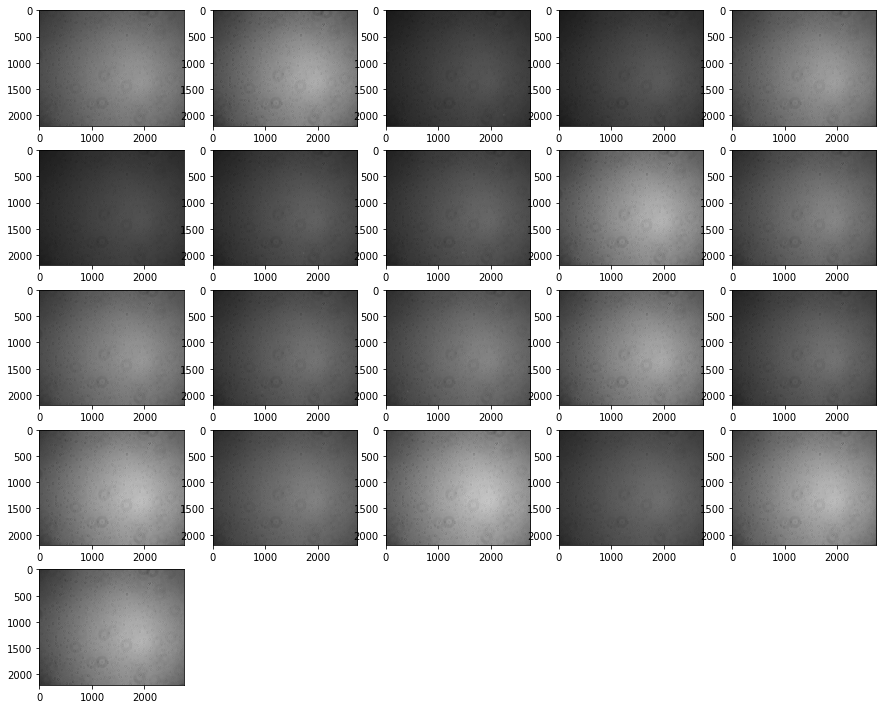

In [30]:
print('Checking V filter flats figures by plotting')

vflats = []
for img in flats:
  data, header = fits.getdata(img,header=True)
  if (header['FILTER']=='V'):
    vflats.append(data)
    print('  ',img,data.shape,header['IMAGETYP'],'filter',header['FILTER'],', EXPTIME :', header['EXPTIME'])


datacube = vflats
import matplotlib.gridspec as gridspec
no_A = len(datacube) 
xplots = int(np.around(np.sqrt(no_A))) 
yplots = xplots + 1 

from matplotlib.colors import LogNorm

gs = gridspec.GridSpec(yplots, xplots) 
plt.figure(figsize=(15,15))
for i in range(no_A): 
  data = datacube[i]
  plt.subplot(gs[i])
  plt.imshow(data, cmap='gray', norm=LogNorm())

Checking B flats figures by plotting
   /work/chuck/chen/obs/20190822/CCD Image 15.fit (2199, 2749) Flat Field filter B , EXPTIME : 1.0
   /work/chuck/chen/obs/20190822/CCD Image 11.fit (2199, 2749) Flat Field filter B , EXPTIME : 1.0
   /work/chuck/chen/obs/20190822/CCD Image 16.fit (2199, 2749) Flat Field filter B , EXPTIME : 1.0
   /work/chuck/chen/obs/20190822/CCD Image 5.fit (2199, 2749) Flat Field filter B , EXPTIME : 1.0
   /work/chuck/chen/obs/20190822/CCD Image 18.fit (2199, 2749) Flat Field filter B , EXPTIME : 2.0
   /work/chuck/chen/obs/20190822/CCD Image 6.fit (2199, 2749) Flat Field filter B , EXPTIME : 1.0
   /work/chuck/chen/obs/20190822/CCD Image 4.fit (2199, 2749) Flat Field filter B , EXPTIME : 1.0
   /work/chuck/chen/obs/20190822/CCD Image 7.fit (2199, 2749) Flat Field filter B , EXPTIME : 1.0
   /work/chuck/chen/obs/20190822/CCD Image 8.fit (2199, 2749) Flat Field filter B , EXPTIME : 1.0
   /work/chuck/chen/obs/20190822/CCD Image 3.fit (2199, 2749) Flat Field filt

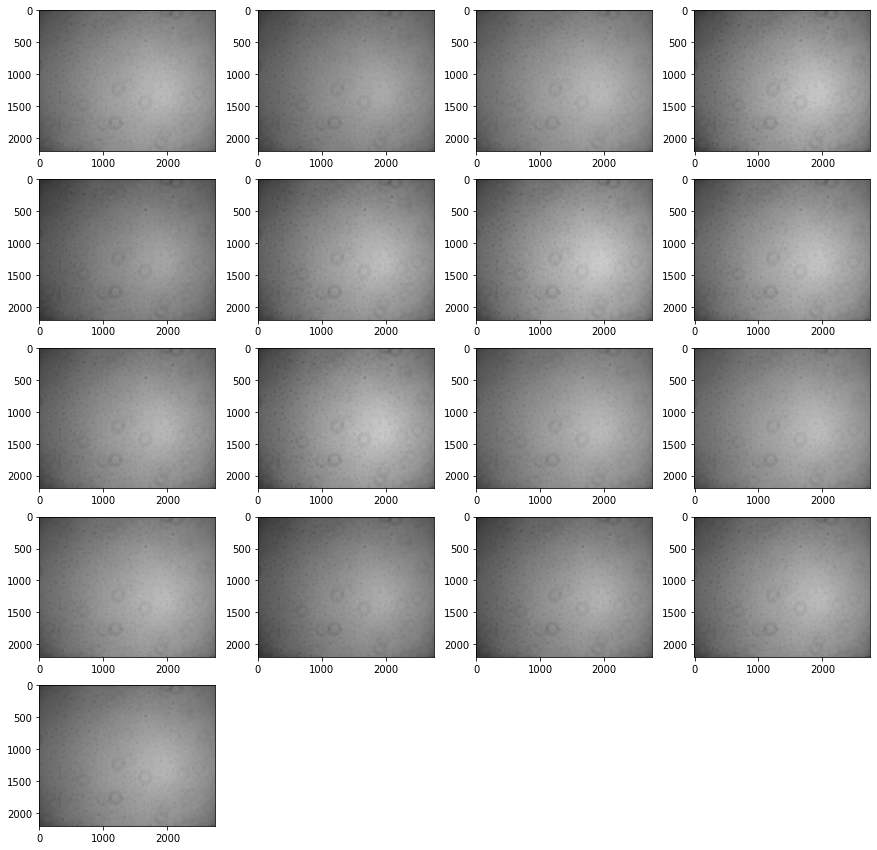

In [31]:
print('Checking B flats figures by plotting')

Bflats = []
for img in flats:
  data, header = fits.getdata(img,header=True)
  if (header['FILTER']=='B'):
    Bflats.append(data)
    print('  ',img,data.shape,header['IMAGETYP'],'filter',header['FILTER'],', EXPTIME :', header['EXPTIME'])

datacube = Bflats
import matplotlib.gridspec as gridspec
no_A = len(datacube) 
xplots = int(np.around(np.sqrt(no_A))) 
yplots = xplots + 1 

from matplotlib.colors import LogNorm

gs = gridspec.GridSpec(yplots, xplots) 
plt.figure(figsize=(15,15))
for i in range(no_A): 
  data = datacube[i]
  plt.subplot(gs[i])
  plt.imshow(data, cmap='gray', norm=LogNorm())

Checking U flats figures by plotting
   /work/chuck/chen/obs/20190822/CCD Image 2.fit (2199, 2749) Flat Field filter U , EXPTIME : 0.1


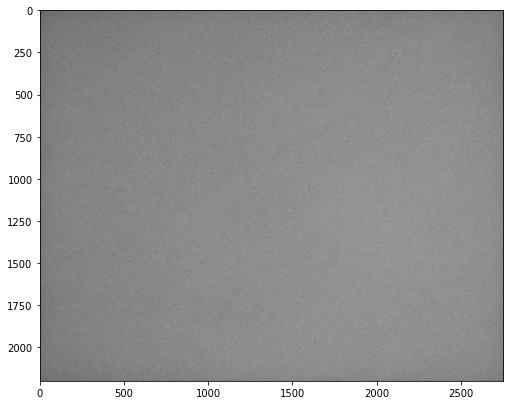

In [35]:
print('Checking U flats figures by plotting')

Uflats = []
for img in flats:
  data, header = fits.getdata(img,header=True)
  if (header['FILTER']=='U'):
    Uflats.append(data)
    print('  ',img,data.shape,header['IMAGETYP'],'filter',header['FILTER'],', EXPTIME :', header['EXPTIME'])

datacube =Uflats
import matplotlib.gridspec as gridspec
no_A = len(datacube) 
xplots = int(np.around(np.sqrt(no_A))) 
yplots = xplots + 1 

from matplotlib.colors import LogNorm

gs = gridspec.GridSpec(yplots, xplots) 
plt.figure(figsize=(15,15))
for i in range(no_A): 
  data = datacube[i]
  plt.subplot(gs[i])
  plt.imshow(data, cmap='gray', norm=LogNorm())

Checking I flats figures by plotting
   /work/chuck/chen/obs/20190822/CCD Image 43.fit (2199, 2749) Flat Field filter I , EXPTIME : 30.0
   /work/chuck/chen/obs/20190822/CCD Image 41.fit (2199, 2749) Flat Field filter I , EXPTIME : 7.0
   /work/chuck/chen/obs/20190822/CCD Image 42.fit (2199, 2749) Flat Field filter I , EXPTIME : 25.0


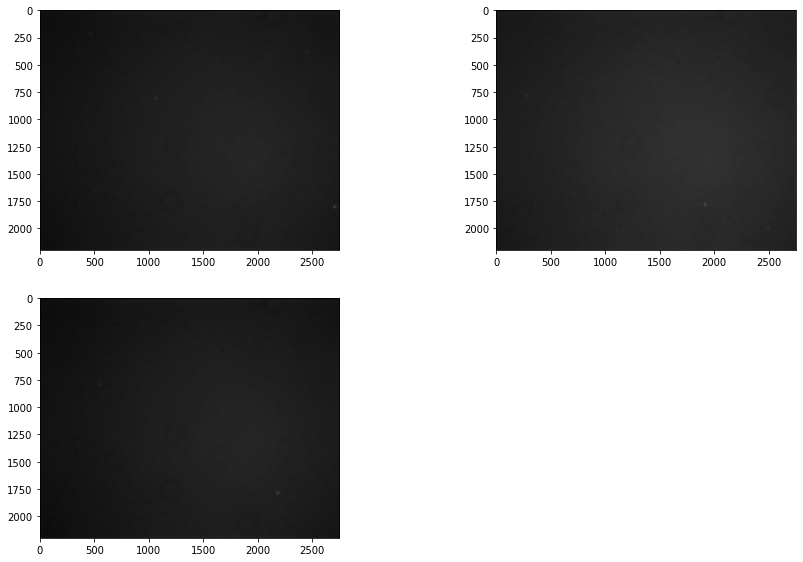

In [34]:
print('Checking I flats figures by plotting')

Iflats = []
for img in flats:
  data, header = fits.getdata(img,header=True)
  if (header['FILTER']=='I'):
    Iflats.append(data)
    print('  ',img,data.shape,header['IMAGETYP'],'filter',header['FILTER'],', EXPTIME :', header['EXPTIME'])

datacube = Iflats
import matplotlib.gridspec as gridspec
no_A = len(datacube) 
xplots = int(np.around(np.sqrt(no_A))) 
yplots = xplots + 1 

from matplotlib.colors import LogNorm

gs = gridspec.GridSpec(yplots, xplots) 
plt.figure(figsize=(15,15))
for i in range(no_A): 
  data = datacube[i]
  plt.subplot(gs[i])
  plt.imshow(data, cmap='gray', norm=LogNorm())

Checking bias and creating master bias
  img : /work/chuck/chen/obs/20190822/bias-0014.fit , data shape (2199, 2749) , EXPTIME : 0.0
  img : /work/chuck/chen/obs/20190822/bias-0003.fit , data shape (2199, 2749) , EXPTIME : 0.0
  img : /work/chuck/chen/obs/20190822/bias-0005.fit , data shape (2199, 2749) , EXPTIME : 0.0
  img : /work/chuck/chen/obs/20190822/bias-0006.fit , data shape (2199, 2749) , EXPTIME : 0.0
  img : /work/chuck/chen/obs/20190822/bias-0013.fit , data shape (2199, 2749) , EXPTIME : 0.0
  img : /work/chuck/chen/obs/20190822/bias-0012.fit , data shape (2199, 2749) , EXPTIME : 0.0
  img : /work/chuck/chen/obs/20190822/bias-0011.fit , data shape (2199, 2749) , EXPTIME : 0.0
  img : /work/chuck/chen/obs/20190822/bias-0002.fit , data shape (2199, 2749) , EXPTIME : 0.0
  img : /work/chuck/chen/obs/20190822/bias-0010.fit , data shape (2199, 2749) , EXPTIME : 0.0
  img : /work/chuck/chen/obs/20190822/bias-0007.fit , data shape (2199, 2749) , EXPTIME : 0.0
  img : /work/chuck/c

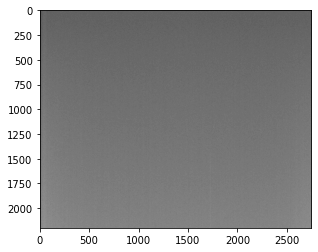

In [49]:
print('Checking bias and creating master bias')
for img in biass:
  data,header = fits.getdata(img,header=True)
  print('  img :',img,', data shape',data.shape,', EXPTIME :', header['EXPTIME'])
#hdul.info()
#print(repr(hdul[0].header))

data_biass = [fits.getdata(img) for img in biass]
#master_bias = np.sum(img_concat, axis=0)/len(biass)
master_bias = np.median(data_biass,axis=0)
master_bias = CCDData(master_bias, unit=u.electron)
plt.imshow(master_bias, cmap='gray', norm=LogNorm())


  img : /work/chuck/chen/obs/20190822/bias-0003.fit , data shape (2199, 2749) , EXPTIME : 0.0
  img : /work/chuck/chen/obs/20190822/bias-0005.fit , data shape (2199, 2749) , EXPTIME : 0.0
  img : /work/chuck/chen/obs/20190822/bias-0006.fit , data shape (2199, 2749) , EXPTIME : 0.0


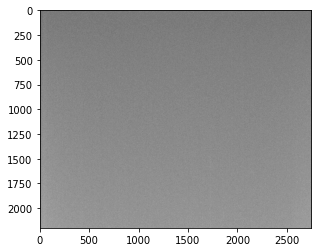

In [47]:
from ccdproc import combine

bias_list = []
for img in biass[1:4]:
  data,header = fits.getdata(img,header=True)
  print('  img :',img,', data shape',data.shape,', EXPTIME :', header['EXPTIME'])
  ccd = CCDData.read(img, unit=u.adu)
  bias_list.append(ccd)

#master_bias = combine(bias_list, method='median')
biases = ccdproc.Combiner(bias_list)
master_bias = biases.average_combine()

plt.imshow(master_bias, cmap='gray', norm=LogNorm())